The most common example of a system that exhibits chaos is the double pendulum. In the double pendulum setting we know that small perturbations to the initial conditions significantly influence the trajectory. How best can we capture such changes?

The lagrangian of a system is:

$$ L = T(q,\dot{q}) - V(q) $$ and $$ \frac{d}{dt}\frac{\partial L}{\partial \dot{q}} - \frac{\partial L}{\partial q} = \tau$$

gives us the Euler-Lagrange equation with generalized forces

If $ T = \dot{q}^T M(q) \dot{q} $ and V is only a function of q, then:

$$ \frac{\partial L}{\partial \dot{q}} = p = M(q)\dot{q}$$

$$ \frac{d}{dt}\frac{\partial L}{\partial \dot{q}} = \frac{dp}{dt} = \dot{M(q)}\dot{q} + M(q)\ddot{q} $$

Then,if we have no generalized forces:

$$\dot{M(q)}\dot{q} + M(q)\ddot{q} - \frac{\partial L}{\partial q} = 0 $$

$$ \ddot{q} = M(q)^{-1} (\frac{\partial L}{\partial q} - \dot{M(q)} \dot{q}) $$

Deep Lagrangian Nets https://arxiv.org/pdf/1907.04490.pdf - solves the above equation by learning each component and breaking the lagrangian L into a lower triangular times its transpose.

One unique aspect about VIGN is that we don't need to explicitly model the time derivative of M which is a bottle neck of the approach given above. so:

Given $[q_t,\dot{q_t}]$ $\rightarrow$ L $\rightarrow [p_t,\dot{p_t}] $ so now the state is basically:

given our initial state, we want to be able to update $[q_t,\dot{q_t}]$, the way to do this is:

$$ dq_t/dt = \dot{q_t}$$
$$ dp_t/dt = dL/dq $$

$$[q_{t+1},p_{t+1}] $$, but, if we learn M(q) then $$[q_{t+1},M^{-1}(q_{t+1})p_{t+1})]$$

***

In [1]:
from data_builder import *
from utils import *
from model import *
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
expt_name = 'test'
num_trajectories = 1
n_test_traj = 1
num_nodes = 2
T_max = 10.01
dt = 0.01
srate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


train_data = doublepend( expt_name, num_trajectories, num_nodes, T_max, dt, srate, 0,yflag=False)
valid_data = doublepend( expt_name, n_test_traj, num_nodes, 2*T_max,dt,srate, 1,yflag=False)



cpu


In [3]:
x1,y1,x2,y2 = theta_to_cart(train_data['x'])
x1_t,y1_t,x2_t,y2_t = theta_to_cart(valid_data['x'])

<AxesSubplot:>

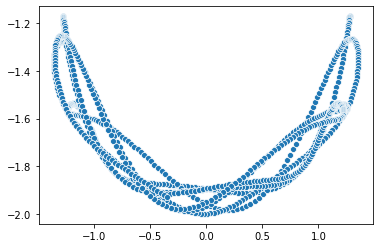

In [4]:
# sns.scatterplot(x=x1,y=y1)
sns.scatterplot(x=x2,y=y2)
# sns.scatterplot(x=x1,y=y1)
# sns.scatterplot(x=x2_t,y=y2_t)

In [5]:
def omega(state):
    pt1 = state[:,2] + state[:,3]*np.cos(state[:,0]-state[:,1])
    pt2 = state[:,3] + state[:,2]*np.cos(state[:,0]-state[:,1])
    return np.concatenate([state[:,:2],pt1.reshape(-1,1),pt2.reshape(-1,1)],1)

In [6]:
tnow,tnext = nownext(train_data,num_trajectories,num_nodes,T_max,dt,srate,spatial_dim=2)
tnow = omega(tnow[0])
tnext = omega(tnext[0])

In [7]:
train_data['energy']

array([-20.83300139, -20.83300139, -20.83300139, ..., -20.83300139,
       -20.83300139, -20.83300139])

In [10]:
traindat = pendpixdata(tnow, tnext)
train_dataloader = DataLoader(traindat, batch_size=200, num_workers=2, shuffle=True)
# # valdat = pendpixdata(test_xnow, test_xnext)
# val_dataloader = DataLoader(valdat, batch_size=bs_test, num_workers=nw, shuffle=False)
data_dict = {'train': train_dataloader}
running_losses = 0.

torch.pi = torch.tensor(np.pi)
def rebase(q):
    qs= (q[:,:2] + torch.pi) % (2 * torch.pi) - torch.pi
    qdots = q[:,2:]
    return torch.cat([qs,qdots],1)
def train_model(model, optimizer, num_epochs=1):

    for epoch in range(num_epochs):
        print('epoch:{}'.format(epoch))

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                # scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            # Iterate over data.
            for batch_i, (q, q_next) in enumerate(data_dict[phase]):
                if phase == 'train':
                    optimizer.zero_grad()
                q, q_next = q.float(), q_next.float()
                q.to(device)
                q_next.to(device)
                q.requires_grad = True
                loss = 0
                energy_ = torch.ones(size=q.shape)*train_data['energy'][0]
                if phase == 'train':
                    t1 =time.time()
                    next_step_pred = model.next_step(rebase(q))
                    state_loss = 0#((rebase(next_step_pred) - rebase(q_next)) ** 2).mean()
                    energy_loss = ((model.forward(rebase(q))-energy_)**2).mean()
                    loss +=  state_loss + energy_loss
                    (loss).backward()
                    print(f'energy:{energy_loss},state:{state_loss}')
                    optimizer.step()
                running_loss += loss.item()
            epoch_loss = running_loss
            print('{} Loss: {:.10f}'.format(phase, epoch_loss))

            
    return model


model_ft = MODEL(4, 400, 1)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-3)
model_ft = train_model(model_ft, optimizer_ft, num_epochs=1000)


epoch:0
energy:414.530029296875,state:0
energy:356.8557434082031,state:0
energy:304.8324890136719,state:0
energy:257.06964111328125,state:0
energy:214.91015625,state:0
train Loss: 1548.1980590820
epoch:1
energy:178.8490753173828,state:0
energy:147.5556640625,state:0
energy:119.02406311035156,state:0
energy:96.63553619384766,state:0
energy:75.5508041381836,state:0
train Loss: 617.6151428223
epoch:2
energy:60.476680755615234,state:0
energy:48.02928161621094,state:0
energy:36.08808517456055,state:0
energy:28.281740188598633,state:0
energy:21.023256301879883,state:0
train Loss: 193.8990440369
epoch:3
energy:15.293115615844727,state:0
energy:10.948957443237305,state:0
energy:7.368535995483398,state:0
energy:4.5693678855896,state:0
energy:3.0545876026153564,state:0
train Loss: 41.2345645428
epoch:4
energy:1.6531137228012085,state:0
energy:0.7358378767967224,state:0
energy:0.2058018445968628,state:0
energy:0.036633558571338654,state:0
energy:0.0829530730843544,state:0
train Loss: 2.7143400759

energy:0.0008561746799387038,state:0
train Loss: 0.0046992304
epoch:39
energy:0.0009840417187660933,state:0
energy:0.0008949472103267908,state:0
energy:0.0008478540112264454,state:0
energy:0.0008859793888404965,state:0
energy:0.0010543414391577244,state:0
train Loss: 0.0046671638
epoch:40
energy:0.000888931448571384,state:0
energy:0.000833245343528688,state:0
energy:0.0009774292120710015,state:0
energy:0.0009840973652899265,state:0
energy:0.0009522910695523024,state:0
train Loss: 0.0046359944
epoch:41
energy:0.000971763045527041,state:0
energy:0.0009143369388766587,state:0
energy:0.0007977588684298098,state:0
energy:0.0010056813480332494,state:0
energy:0.0009175200248137116,state:0
train Loss: 0.0046070602
epoch:42
energy:0.0009198522311635315,state:0
energy:0.0010078687919303775,state:0
energy:0.0009543642518110573,state:0
energy:0.0008971047354862094,state:0
energy:0.0007983147515915334,state:0
train Loss: 0.0045775048
epoch:43
energy:0.0010290764039382339,state:0
energy:0.0008947253

energy:0.0009295530617237091,state:0
energy:0.0006727780564688146,state:0
energy:0.0006924756453372538,state:0
train Loss: 0.0039894076
epoch:77
energy:0.0009067699429579079,state:0
energy:0.0008365465910173953,state:0
energy:0.0007586029241792858,state:0
energy:0.000655714946333319,state:0
energy:0.0008221302996389568,state:0
train Loss: 0.0039797647
epoch:78
energy:0.0007262761937454343,state:0
energy:0.0007363248732872307,state:0
energy:0.000833204248920083,state:0
energy:0.0007722718291915953,state:0
energy:0.0008970084600150585,state:0
train Loss: 0.0039650856
epoch:79
energy:0.0008846984710544348,state:0
energy:0.0007376603316515684,state:0
energy:0.0008154160459525883,state:0
energy:0.0008315257728099823,state:0
energy:0.0006859877612441778,state:0
train Loss: 0.0039552884
epoch:80
energy:0.0007596655050292611,state:0
energy:0.0007424384821206331,state:0
energy:0.0008298233151435852,state:0
energy:0.0008069186587817967,state:0
energy:0.0007979064248502254,state:0
train Loss: 0.0

energy:0.0006910075899213552,state:0
energy:0.0007553058676421642,state:0
energy:0.0007103655952960253,state:0
energy:0.0006932402611710131,state:0
energy:0.0006662918603979051,state:0
train Loss: 0.0035162112
epoch:115
energy:0.0007534001488238573,state:0
energy:0.0007523093954659998,state:0
energy:0.0006840263376943767,state:0
energy:0.0007169764721766114,state:0
energy:0.0005918192910030484,state:0
train Loss: 0.0034985316
epoch:116
energy:0.0007233286160044372,state:0
energy:0.0007892202120274305,state:0
energy:0.0006521789473481476,state:0
energy:0.0006352043710649014,state:0
energy:0.0006862112786620855,state:0
train Loss: 0.0034861434
epoch:117
energy:0.0007776673883199692,state:0
energy:0.000636263401247561,state:0
energy:0.0006047481438145041,state:0
energy:0.0006752909976057708,state:0
energy:0.0007795141427777708,state:0
train Loss: 0.0034734841
epoch:118
energy:0.0007284434977918863,state:0
energy:0.0006572710699401796,state:0
energy:0.0006716784555464983,state:0
energy:0.0

energy:0.0006644746754318476,state:0
energy:0.0005865134880878031,state:0
train Loss: 0.0030607612
epoch:152
energy:0.0005958036053925753,state:0
energy:0.000636388489510864,state:0
energy:0.0006100211758166552,state:0
energy:0.0005875617498531938,state:0
energy:0.000617736775893718,state:0
train Loss: 0.0030475118
epoch:153
energy:0.0006511032697744668,state:0
energy:0.0006539159803651273,state:0
energy:0.0005795033648610115,state:0
energy:0.0006483151810243726,state:0
energy:0.0005039160023443401,state:0
train Loss: 0.0030367538
epoch:154
energy:0.0006374761578626931,state:0
energy:0.0005726585513912141,state:0
energy:0.0005759105551987886,state:0
energy:0.0006266233394853771,state:0
energy:0.0006126511725597084,state:0
train Loss: 0.0030253198
epoch:155
energy:0.0005189793300814927,state:0
energy:0.000673023285344243,state:0
energy:0.0006866063922643661,state:0
energy:0.0005223611369729042,state:0
energy:0.000611398252658546,state:0
train Loss: 0.0030123684
epoch:156
energy:0.000639

energy:0.0005318780313245952,state:0
energy:0.0005205808556638658,state:0
energy:0.0005094224470667541,state:0
energy:0.0005241311155259609,state:0
energy:0.0005441198591142893,state:0
train Loss: 0.0026301323
epoch:190
energy:0.0005090264021418989,state:0
energy:0.0005209362716414034,state:0
energy:0.0005406987620517612,state:0
energy:0.000515097810421139,state:0
energy:0.0005328732077032328,state:0
train Loss: 0.0026186325
epoch:191
energy:0.0005580054712481797,state:0
energy:0.0005539037520065904,state:0
energy:0.0004715009708888829,state:0
energy:0.0005174021935090423,state:0
energy:0.0005099690752103925,state:0
train Loss: 0.0026107815
epoch:192
energy:0.0005190485971979797,state:0
energy:0.0004922761581838131,state:0
energy:0.0004906464018858969,state:0
energy:0.0005594341200776398,state:0
energy:0.0005404626717790961,state:0
train Loss: 0.0026018679
epoch:193
energy:0.0005093545187264681,state:0
energy:0.0005816667689941823,state:0
energy:0.0004766772617585957,state:0
energy:0.0

energy:0.00045219145249575377,state:0
energy:0.0004493753658607602,state:0
train Loss: 0.0022580147
epoch:227
energy:0.0004240365233272314,state:0
energy:0.0005364031530916691,state:0
energy:0.0004551413294393569,state:0
energy:0.0004348132060840726,state:0
energy:0.000397125375457108,state:0
train Loss: 0.0022475196
epoch:228
energy:0.00044200275442563,state:0
energy:0.00040992721915245056,state:0
energy:0.000505328003782779,state:0
energy:0.00041306213825009763,state:0
energy:0.0004728925123345107,state:0
train Loss: 0.0022432126
epoch:229
energy:0.0004189402097836137,state:0
energy:0.00044556139619089663,state:0
energy:0.0004472934524528682,state:0
energy:0.00046027626376599073,state:0
energy:0.00045645172940567136,state:0
train Loss: 0.0022285231
epoch:230
energy:0.0004063638625666499,state:0
energy:0.0004023356013931334,state:0
energy:0.0004791237006429583,state:0
energy:0.00047093487228266895,state:0
energy:0.00046052210382185876,state:0
train Loss: 0.0022192801
epoch:231
energy:

energy:0.00042740171193145216,state:0
energy:0.00035226691397838295,state:0
train Loss: 0.0019307496
epoch:264
energy:0.00032662530429661274,state:0
energy:0.00033450868795625865,state:0
energy:0.00042529497295618057,state:0
energy:0.00039739225758239627,state:0
energy:0.0004402447084430605,state:0
train Loss: 0.0019240659
epoch:265
energy:0.00037044219789095223,state:0
energy:0.00041946631972678006,state:0
energy:0.00038120546378195286,state:0
energy:0.0003666388220153749,state:0
energy:0.0003779385588131845,state:0
train Loss: 0.0019156914
epoch:266
energy:0.00036325588007457554,state:0
energy:0.00041708856588229537,state:0
energy:0.00038505851989611983,state:0
energy:0.0003705764247570187,state:0
energy:0.00037193295429460704,state:0
train Loss: 0.0019079123
epoch:267
energy:0.0003630661522038281,state:0
energy:0.00037625193363055587,state:0
energy:0.0004049928393214941,state:0
energy:0.00037823375896550715,state:0
energy:0.0003769349423237145,state:0
train Loss: 0.0018994796
epoch:

energy:0.00033970328513532877,state:0
train Loss: 0.0016511075
epoch:301
energy:0.00030692413565702736,state:0
energy:0.0003353555512148887,state:0
energy:0.00034832244273275137,state:0
energy:0.00033549629733897746,state:0
energy:0.0003183834196534008,state:0
train Loss: 0.0016444818
epoch:302
energy:0.00030239333864301443,state:0
energy:0.0003259766090195626,state:0
energy:0.0003222966624889523,state:0
energy:0.0003312372136861086,state:0
energy:0.0003581053460948169,state:0
train Loss: 0.0016400092
epoch:303
energy:0.0003530008834786713,state:0
energy:0.00031092792050912976,state:0
energy:0.0003192478325217962,state:0
energy:0.00034889235394075513,state:0
energy:0.00030324439285323024,state:0
train Loss: 0.0016353134
epoch:304
energy:0.0003591773274820298,state:0
energy:0.00031983701046556234,state:0
energy:0.0002831644378602505,state:0
energy:0.0003188610135111958,state:0
energy:0.00034274611971341074,state:0
train Loss: 0.0016237859
epoch:305
energy:0.00031273497734218836,state:0


energy:0.0002432821929687634,state:0
train Loss: 0.0014092948
epoch:338
energy:0.00030167639488354325,state:0
energy:0.0002589939977042377,state:0
energy:0.0003017839335370809,state:0
energy:0.00027752245659939945,state:0
energy:0.0002620922459755093,state:0
train Loss: 0.0014020690
epoch:339
energy:0.00024366806610487401,state:0
energy:0.0003238768840674311,state:0
energy:0.0002541381982155144,state:0
energy:0.00032614043448120356,state:0
energy:0.00024958295398391783,state:0
train Loss: 0.0013974065
epoch:340
energy:0.00028594519244506955,state:0
energy:0.00028763606678694487,state:0
energy:0.0002657975710462779,state:0
energy:0.0002677211305126548,state:0
energy:0.0002843799302354455,state:0
train Loss: 0.0013914799
epoch:341
energy:0.0002948394394479692,state:0
energy:0.0002690524561330676,state:0
energy:0.0002552401274442673,state:0
energy:0.0002985954633913934,state:0
energy:0.00026760564651340246,state:0
train Loss: 0.0013853331
epoch:342
energy:0.00032864807872101665,state:0
en

energy:0.0002656797878444195,state:0
train Loss: 0.0012007002
epoch:375
energy:0.00021316451602615416,state:0
energy:0.0002639502636156976,state:0
energy:0.0002343983796890825,state:0
energy:0.00023250828962773085,state:0
energy:0.00025245570577681065,state:0
train Loss: 0.0011964772
epoch:376
energy:0.00021735882910434157,state:0
energy:0.0002351096336496994,state:0
energy:0.0002260945620946586,state:0
energy:0.00026887291460298,state:0
energy:0.0002480966504663229,state:0
train Loss: 0.0011955326
epoch:377
energy:0.00023038606741465628,state:0
energy:0.0002374474861426279,state:0
energy:0.00027319713262841105,state:0
energy:0.00021661190839949995,state:0
energy:0.0002258419553982094,state:0
train Loss: 0.0011834845
epoch:378
energy:0.0002228699013357982,state:0
energy:0.00023476299247704446,state:0
energy:0.00023889902513474226,state:0
energy:0.00025643091066740453,state:0
energy:0.00023408589186146855,state:0
train Loss: 0.0011870487
epoch:379
energy:0.00023586704628542066,state:0
e

energy:0.00021404950530268252,state:0
energy:0.0001917898334795609,state:0
energy:0.0001905958924908191,state:0
energy:0.00023017203784547746,state:0
energy:0.00019281073764432222,state:0
train Loss: 0.0010194180
epoch:413
energy:0.00018710768199525774,state:0
energy:0.00021741139062214643,state:0
energy:0.00021157335140742362,state:0
energy:0.00021304770780261606,state:0
energy:0.00018677992920856923,state:0
train Loss: 0.0010159201
epoch:414
energy:0.00020551755733322352,state:0
energy:0.00023213503300212324,state:0
energy:0.00019043349311687052,state:0
energy:0.00019704678561538458,state:0
energy:0.0001850965927587822,state:0
train Loss: 0.0010102295
epoch:415
energy:0.00016565572877880186,state:0
energy:0.00024593688431195915,state:0
energy:0.00020947288430761546,state:0
energy:0.00018089641525875777,state:0
energy:0.00020377550390549004,state:0
train Loss: 0.0010057374
epoch:416
energy:0.0002017081278609112,state:0
energy:0.0001926511904457584,state:0
energy:0.0001786788197932765,

energy:0.00018430862110108137,state:0
energy:0.00018326271674595773,state:0
energy:0.00018611557607073337,state:0
energy:0.00015252553566824645,state:0
energy:0.0001605705765541643,state:0
train Loss: 0.0008667830
epoch:450
energy:0.00017556577222421765,state:0
energy:0.00015748872829135507,state:0
energy:0.0001499754434917122,state:0
energy:0.0001991167664527893,state:0
energy:0.00018069219368044287,state:0
train Loss: 0.0008628389
epoch:451
energy:0.00019658103701658547,state:0
energy:0.0001813676062738523,state:0
energy:0.0001613931672181934,state:0
energy:0.00013636131188832223,state:0
energy:0.00018343300325796008,state:0
train Loss: 0.0008591361
epoch:452
energy:0.00017545846640132368,state:0
energy:0.000179292619577609,state:0
energy:0.00016590287850704044,state:0
energy:0.00016782619059085846,state:0
energy:0.00016718596452847123,state:0
train Loss: 0.0008556661
epoch:453
energy:0.00014795908646192402,state:0
energy:0.00016766121552791446,state:0
energy:0.0001852756249718368,st

energy:0.000146903854329139,state:0
energy:0.00013007308007217944,state:0
energy:0.0001420149055775255,state:0
energy:0.0001685012539383024,state:0
energy:0.00014917839143890887,state:0
train Loss: 0.0007366715
epoch:487
energy:0.000138820571010001,state:0
energy:0.00013857429439667612,state:0
energy:0.00016111420700326562,state:0
energy:0.00015262619126588106,state:0
energy:0.0001399001048412174,state:0
train Loss: 0.0007310354
epoch:488
energy:0.0001541633828310296,state:0
energy:0.00015828020696062595,state:0
energy:0.0001463534135837108,state:0
energy:0.00014026410644873977,state:0
energy:0.00013198643864598125,state:0
train Loss: 0.0007310475
epoch:489
energy:0.0001494817843195051,state:0
energy:0.00016104723908938468,state:0
energy:0.00014551855565514416,state:0
energy:0.00013816832506563514,state:0
energy:0.00013047797256149352,state:0
train Loss: 0.0007246939
epoch:490
energy:0.0001665981108089909,state:0
energy:0.0001364999043289572,state:0
energy:0.00012455479009076953,state:

KeyboardInterrupt: 

In [23]:
it = iter(data_dict['train'])
q,q_next = next(it)

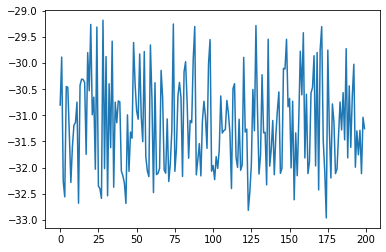

In [27]:
plt.plot(model_ft.forward(q.float()).detach().numpy())

In [9]:
q.shape

NameError: name 'q' is not defined

In [19]:
q=torch.tensor(tnow[0]).float().reshape(-1,4)
q.to(device)
q.requires_grad = True
loss = 0
coll = []
for _ in range(100):
    nstep = model_ft.next_step(q)
    coll.append(nstep.detach().numpy()[0])
    q=nstep
    
                    

In [20]:
coll = np.array(coll)

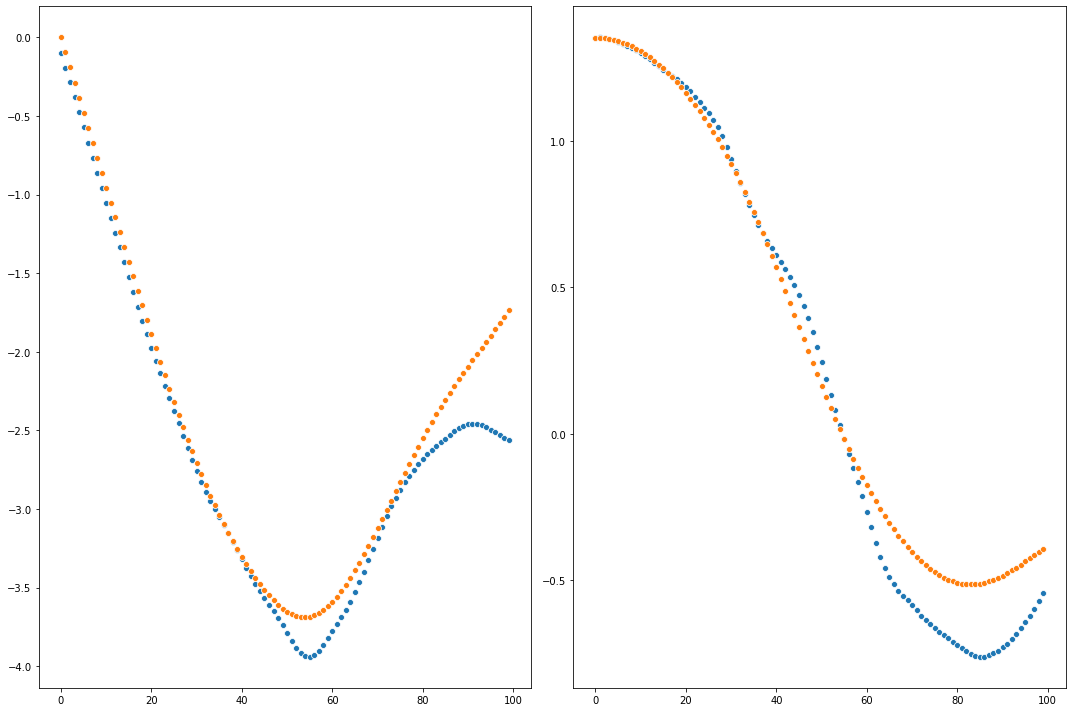

In [21]:
N = 100
fig,axs = plt.subplots(1,2,figsize=(15,10))
sns.scatterplot(x=range(N),y=coll[:N,3],ax=axs[0])
sns.scatterplot(x=range(N),y=tnow[:N,3],ax=axs[0])
sns.scatterplot(x=range(N),y=coll[:N,1],ax=axs[1])
sns.scatterplot(x=range(N),y=tnow[:N,1],ax=axs[1])
plt.tight_layout()

In [ ]:
# x1_p,y1_p,x2_p,y2_p = theta_to_cart(np.array(coll))

In [ ]:
# x1_p.shape

In [ ]:
# sns.scatterplot(x=x2_p[:50],y=y2_p[:50])
# sns.scatterplot(x=x2[:50],y=y2[:50])

In [ ]:

N = 500
fig,axs = plt.subplots(1,2,figsize=(15,10))
sns.scatterplot(x=range(N),y=y2_p[:N],ax=axs[0])
sns.scatterplot(x=range(N),y=y2[:N],ax=axs[0])
sns.scatterplot(x=range(N),y=x2_p[:N],ax=axs[1])
sns.scatterplot(x=range(N),y=x2[:N],ax=axs[1])
plt.tight_layout()

In [ ]:
x2.shape

In [ ]:
torch.pi

In [ ]:
np.pi

In [ ]:
for batch_i, (q, dq) in enumerate(data_dict['train']):
    print(batch_i)

In [ ]:
model_ft.M_matrix(q[:,:2].float())

In [ ]:
model_ft.Minv

In [ ]:
torch.inverse(model_ft.M[:2,:2])